# Determining the sparsity cutoff that produces the highest number of rejected hypotheses (alternative to DESeq2's independent filtering)

# Setting variables

In [2]:
workDir = '/home/chantal/Chazy/Chazy_SIP/data/Replicates'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqSIP = 'SIP_unk'


#biomFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/OTU_binning/otu_table_wtax.biom'
#metadataFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-7/metadata_SIP.txt'
#treeFile = '/home/nick/notebook/fullCyc/data/MiSeq_16S/515f-806r/V4_Lib1-6/fasttree/otusn.tree'


# l2fc params
l2fc_threshold = 1
BD_min = 1.7125    # from Ashley's succ-C paper; G+C =~ 0.54
BD_max = 2

# misc
nprocs = 10

# Init

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R
library(DESeq2)
library(phyloseq)
library(grid); library(gridExtra)
library(plyr); library(dplyr)
library(tidyr)
library(ggplot2)
library(doParallel)
library(foreach)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: S4Vectors

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: stats4

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: BiocGenerics

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Loading required package: parallel

  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘BiocGenerics’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/funct

In [11]:
%%R -i l2fc_threshold -i BD_min -i BD_max -i nprocs
cat('Params loaded in R\n')

Params loaded in R


In [14]:
%%R -i physeqDir -i physeqSIP

F = file.path(physeqDir, physeqSIP)
print(F)
physeq.SIP = readRDS(F)
physeq.SIP.m = physeq.SIP %>% sample_data
physeq.SIP = prune_samples(!(physeq.SIP.m$Full.sample %in% c('12C.PTH.D30.R3_Frac26','12C.NTH.D3.R4.Frac9')),
                           physeq.SIP) %>% filter_taxa(function(x) sum(x) > 0, TRUE)

physeq.SIP

[1] "/home/chantal/Chazy/data/phyloseq//SIP_unk"
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23344 taxa and 993 samples ]
sample_data() Sample Data:       [ 993 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 23344 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 23344 tips and 23343 internal nodes ]


In [15]:
%%R
physeq.SIP.m$Substrate = physeq.SIP.m$Treatment
physeq.SIP = merge_phyloseq(physeq.SIP, physeq.SIP.m)
physeq.SIP

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 23344 taxa and 993 samples ]
sample_data() Sample Data:       [ 993 samples by 26 sample variables ]
tax_table()   Taxonomy Table:    [ 23344 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 23344 tips and 23343 internal nodes ]


In [18]:
%%R
unique(physeq.SIP.m$Replicate)

[1] 4 2 3


In [20]:
%%R
# check on number of gradients

n.gradient = physeq.SIP %>% sample_data %>% as.matrix %>% as.data.frame %>%
            distinct(Day, Substrate, Land_Management, Replicate) %>% nrow
cat('Number of gradients:', n.gradient, '\n')

Number of gradients: 42 


In [22]:
%%R
     
asNumeric = function(x) { as.numeric(as.character(x)) }

get_Ps = function(physeq.obj, Substrate, Day, Replicate, Land_Management,
                  density.min, density.max, l2fc_threshold, sparsity_threshold) {
    # function for calculating log2 fold change p-values
    

    Substrate = c(Substrate %>% as.character)
    
    physeq.md = sample_data(physeq.obj)
    # filtering
    p.12C = prune_samples((physeq.md$Substrate == "12C") &
                          (physeq.md$Day == Day) &
                          (physeq.md$Replicate == Replicate) & 
                          (physeq.md$Land_Management == Land_Management) &
                          (physeq.md$Density >= density.min)&
                          (physeq.md$Density <= density.max), 
                           physeq.obj)

    p.13C = prune_samples((physeq.md$Substrate == Substrate) &
                      (physeq.md$Day == Day) &
                      (physeq.md$Replicate == Replicate) & 
                      (physeq.md$Land_Management == Land_Management) &
                      (physeq.md$Density >= density.min)&
                      (physeq.md$Density <= density.max), 
                      physeq.obj)

    physeq.m = merge_phyloseq(p.12C, p.13C)

    physeq.m = filter_taxa(physeq.m, function(x) sum(x > 0) > sparsity_threshold * length(x), TRUE)
  

    
    # deseq
    dds = phyloseq_to_deseq2(physeq.m, ~Substrate)
    dds = DESeq(dds, quiet = TRUE, fitType = "local")
    theta = l2fc_threshold
        
    # results
    res = results(dds, independentFiltering=FALSE)
    res$OTU = rownames(res)
        
    # p-value
    beta = res$log2FoldChange
    betaSE = res$lfcSE
    p = pnorm(beta, theta, betaSE, lower.tail=FALSE)
    res$p = p
    d = data.frame(res[, c("OTU","log2FoldChange", "p")])
    print(d)
    # p-value adjust
    d$padj = p.adjust(p, method = "BH")
        
    # taxonomy data
    TT = physeq.m %>% tax_table %>% data.frame
    TT$OTU = rownames(TT)
    d = left_join(d, TT, c('OTU'))
    d
}

In [23]:
%%R
# list of substrate-day-microcosm rep combinations
## no 12C-con, because it is the comparison 

sdm = physeq.SIP %>% sample_data %>% 
    filter(! is.na(Density),
           Substrate != '12C') %>%
    select(Substrate, Day, Replicate, Land_Management) %>%
    distinct() %>%
    arrange(Substrate, Replicate, Day, Land_Management) 

sdm %>% nrow %>% print
sdm %>% head(n=5)
sdm

[1] 24
   Substrate Day Replicate Land_Management
1        13C  30         2             NTH
2        13C  30         2             PTH
3        13C  30         3             NTH
4        13C  30         3             PTH
5        13C   3         4             NTH
6        13C   3         4             PTH
7        13C   7         4             NTH
8        13C   7         4             PTH
9        13C  14         4             NTH
10       13C  14         4             PTH
11       13C  30         4             NTH
12       13C  30         4             PTH
13       13X   3         2             NTH
14       13X   3         2             PTH
15       13X   3         3             NTH
16       13X   3         3             PTH
17       13X   1         4             NTH
18       13X   1         4             PTH
19       13X   3         4             NTH
20       13X   3         4             PTH
21       13X   7         4             NTH
22       13X   7         4             PTH
23  

In [24]:
%%R
# adding range of sparsity thresholds (all pairwise)
sdms = sdm %>%
    unite(sdm, Substrate, Day, Replicate, Land_Management, sep='___')

sdms = expand.grid(sdms$sdm,
                    sparsity_threshold = seq(0.05,0.95,0.05)) %>%
    separate(Var1, c('Substrate', 'Day', 'Replicate', 'Land_Management'), sep='___')


cat('Number of pairwise combinations of variables:', sdms %>% nrow, '\n\n')
sdms %>% head(7)

Number of pairwise combinations of variables: 456 

  Substrate Day Replicate Land_Management sparsity_threshold
1       13C  30         2             NTH               0.05
2       13C  30         2             PTH               0.05
3       13C  30         3             NTH               0.05
4       13C  30         3             PTH               0.05
5       13C   3         4             NTH               0.05
6       13C   3         4             PTH               0.05
7       13C   7         4             NTH               0.05


In [ ]:
%%R 
registerDoParallel(nprocs)

# debug
m = sdms %>% head(n=5)

df.l2fc = mdply(sdms,
                get_Ps, 
                .parallel = FALSE, 
                physeq.obj = physeq.SIP,
                density.min = BD_min,
                density.max = BD_max,
                l2fc_threshold = l2fc_threshold) %>% tbl_df

In [ ]:
%%R

head(df.l2fc)

In [ ]:
%%R -i workDir
# saving results

outFile = paste(c(workDir, 'l2fc_all_sparsity_df_replicate'), collapse='/')
saveRDS(df.l2fc, outFile)

## Summing number of rejected hypotheses

In [ ]:
%%R -i workDir
# reading in results
inFile = paste(c(workDir, 'l2fc_all_sparsity_df_replicate'), collapse='/')
df.l2fc = readRDS(inFile)

df.l2fc %>% head(n=3) %>% as.data.frame

In [ ]:
%%R
unique(df.l2fc$Replicate)

In [ ]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH = df.l2fc %>%
    filter(padj < padj.cutoff) %>%
    group_by(sparsity_threshold, Substrate, Day, Replicate, Land_Management) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH %>% head(n=6)

In [ ]:
%%R -w 800 -h 700

df.l2fc.rejH$Day = reorder(df.l2fc.rejH$Day, df.l2fc.rejH$Day %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color= Replicate)) +
    geom_line(aes(color = Replicate)) +
    facet_grid(Substrate ~ Day ~ Land_Management, scales = "free_y") +
    theme_bw() +
    theme(
        text = element_text(size=18)
        )

### Summarize the number of rejected hypotheses for all day-substrate treatments combined

In [ ]:
%%R -w 700 -h 400

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Day = as.character(Day))

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color=Substrate, shape=Day)) +
    geom_smooth(method='loess') +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

In [ ]:
%%R -w 900 -h 700

df.l2fc.rejH = df.l2fc.rejH %>%
    mutate(Day = as.character(Day))

df.l2fc.rejH$Day = reorder(df.l2fc.rejH$Day, df.l2fc.rejH$Day %>% as.numeric)

ggplot(df.l2fc.rejH, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(aes(color=Land_Management, shape=Replicate)) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    facet_grid(Substrate ~ Day,scales = "free_y" ) +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)
        )

In [ ]:
%%R

padj.cutoff = 0.10

df.l2fc.rejH.s = df.l2fc %>%
    filter(padj <= padj.cutoff) %>%
    group_by(sparsity_threshold) %>%
    summarize(n_reject_hypo = n()) %>%
    ungroup

df.l2fc.rejH.s %>% head(n=3) %>% as.data.frame

In [ ]:
%%R
# max number of rejected hypos 
max.rejH = df.l2fc.rejH.s %>%
    arrange(desc(n_reject_hypo)) %>%
    head(n=1)
max.rejH = max.rejH$sparsity_threshold
max.rejH

In [ ]:
%%R -w 450 -h 400

ggplot(df.l2fc.rejH.s, aes(sparsity_threshold, n_reject_hypo)) +
    geom_point(size=3) +
    geom_vline(xintercept=max.rejH, linetype='dashed', alpha=0.5) +
    labs(x='Sparsity threshold', y='Number of rejected hypotheses') +
    theme_bw() +
    theme(
        text = element_text(size=18),
        axis.title.y = element_text(vjust=1)
        )

# Selecting l2fc values for sparsity cutoff with max rejected hypotheses

In [ ]:
%%R
df.l2fc.f = df.l2fc %>%
    filter(sparsity_threshold == max.rejH) %>%
    mutate(Day = as.numeric(Day))

df.l2fc.f %>% nrow

In [ ]:
%%R -i workDir
# Writing out l2fc table

outFile = paste(c(workDir, 'l2fc_sparse-maxRejH_replicate.txt'), collapse='/')
write.table(df.l2fc.f, outFile, sep='\t', quote=FALSE, row.names=FALSE)

## Plotting results

In [5]:
%%R
df.l2fc.f = read.table('data/l2fc_sparse-maxRejH_replicate.txt', header = TRUE, sep = '\t')
head(df.l2fc.f)

  Substrate Day Replicate Land_Management sparsity_threshold       OTU
1       13C  30         2             NTH                0.2  OTU.4940
2       13C  30         2             NTH                0.2  OTU.1739
3       13C  30         2             NTH                0.2  OTU.1813
4       13C  30         2             NTH                0.2   OTU.778
5       13C  30         2             NTH                0.2  OTU.2180
6       13C  30         2             NTH                0.2 OTU.12365
  log2FoldChange         p padj    Rank1            Rank2          Rank3
1     -0.4612852 0.9000943    1 Bacteria  __Acidobacteria        __32-21
2      1.3407702 0.2922958    1 Bacteria __Planctomycetes        __OM190
3      0.1598783 0.9125580    1 Bacteria __Planctomycetes        __OM190
4     -0.8920491 0.9999998    1 Bacteria __Planctomycetes __Pla4_lineage
5      0.5713914 0.7989452    1 Bacteria __Planctomycetes __Pla4_lineage
6     -0.7352655 0.9778281    1 Bacteria __Planctomycetes __Pla4_

In [6]:
%%R
unique(df.l2fc.f$Replicate)

[1] 2 3 4


In [7]:
%%R
df.l2fc.f$ls = as.character(paste(df.l2fc.f$Substrate, df.l2fc.f$Land_Management, sep = "-"))
head(df.l2fc.f) %>% select(Substrate, Land_Management, ls)

  Substrate Land_Management      ls
1       13C             NTH 13C-NTH
2       13C             NTH 13C-NTH
3       13C             NTH 13C-NTH
4       13C             NTH 13C-NTH
5       13C             NTH 13C-NTH
6       13C             NTH 13C-NTH


In [8]:
%%R
df.l2fc.f %>% filter(padj <=0.10) %>% group_by(ls) %>% summarise(resp = length(unique(OTU)))

Source: local data frame [4 x 2]

       ls  resp
    (chr) (int)
1 13C-NTH   610
2 13C-PTH   586
3 13X-NTH   482
4 13X-PTH   282


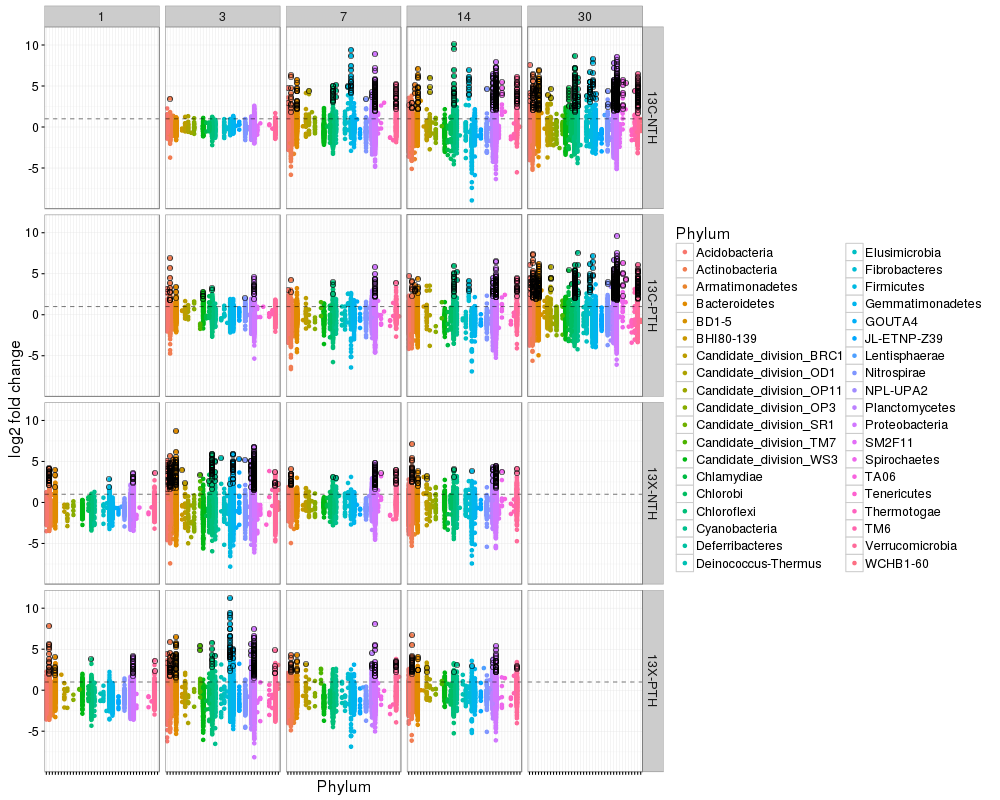

In [9]:
%%R -w 1000 -h 800
padj_cutoff = 0.10
l2fc_threshold = 1

df.l2fc.f = df.l2fc.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.sig = df.l2fc.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc = ggplot(df.l2fc.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls ~ Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank()
        )
p.l2fc

In [10]:
%%R -i figDir
outFile = 'l2fc_sparCut0.2_byPhylum.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc, width=12, height=9)

### Example figure

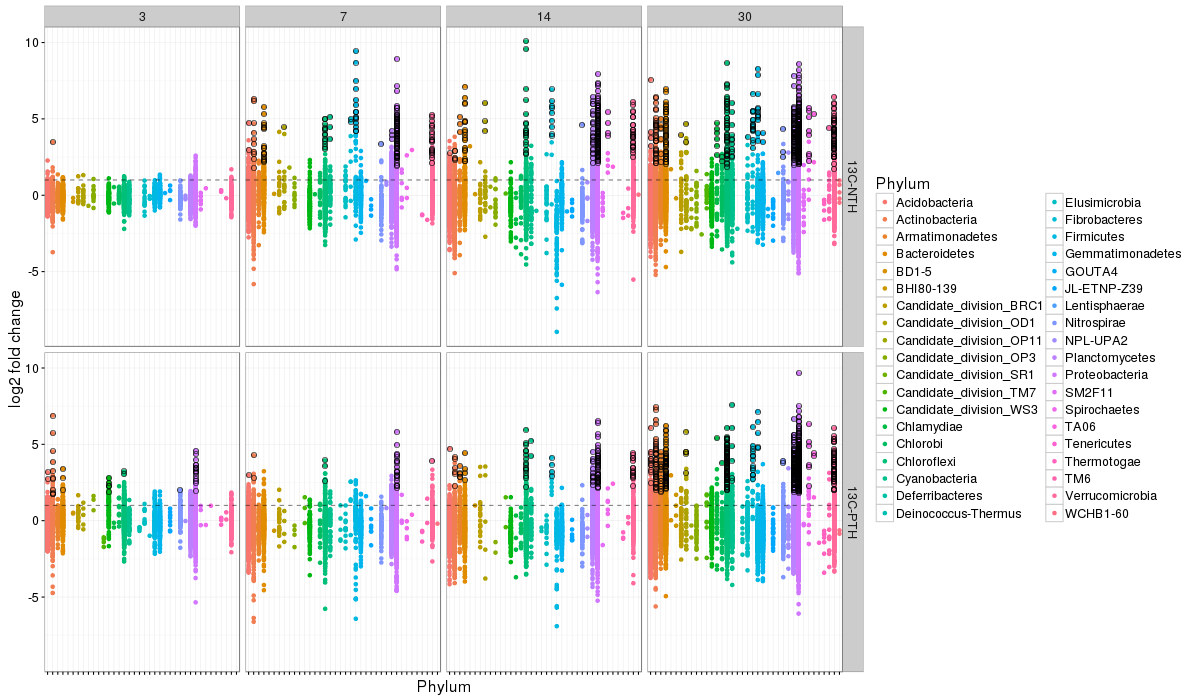

In [11]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13C') %>%
    mutate(Rank2 = Rank2 %>% as.character)

df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank() 
        )
p.l2fc.x

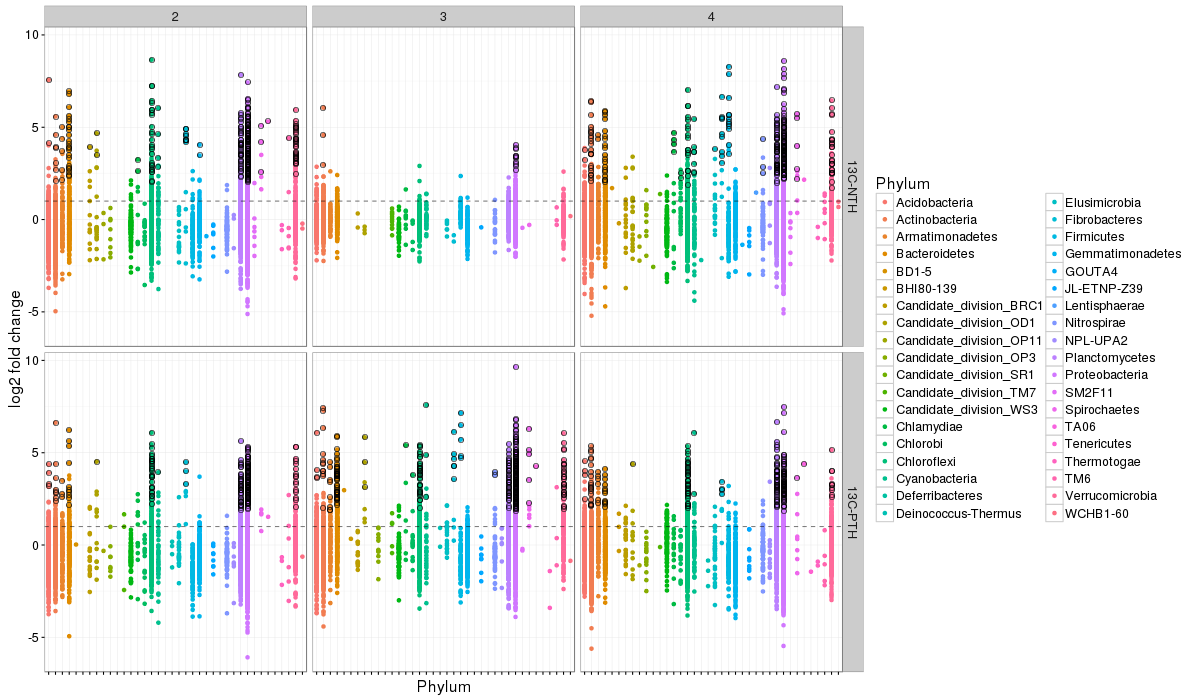

In [12]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.30 = df.l2fc.f %>%
    filter(Substrate == '13C', Day == 30) %>%
    mutate(Rank3 = Rank3 %>% as.character)

df.l2fc.f.30 = df.l2fc.f.30 %>%
    mutate(Rank3 = gsub('^__', '', Rank3))
#df.l2fc.f.f$Phyl = reorder(df.l2fc.f.f$Rank2, -df.l2fc.f.f$log2FoldChange)


df.l2fc.f.30.sig = df.l2fc.f.30 %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank3 = gsub('^__', '', Rank3))
#df.l2fc.f.f.sig$Phyl = reorder(df.l2fc.f.f.sig$Rank2, -df.l2fc.f.f.sig$log2FoldChange)

p.l2fc.x = ggplot(df.l2fc.f.30, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.30.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Replicate) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.text.x = element_blank() 
        )#+ guides(fill = FALSE, color = FALSE)

    
p.l2fc.x

In [13]:
%%R
head(df.l2fc.f.f.sig)

  Substrate Day Replicate Land_Management sparsity_threshold       OTU
1       13C  30         2             NTH                0.2 OTU.16415
2       13C  30         2             NTH                0.2   OTU.785
3       13C  30         2             NTH                0.2  OTU.6408
4       13C  30         2             NTH                0.2  OTU.2914
5       13C  30         2             NTH                0.2  OTU.2659
6       13C  30         2             NTH                0.2  OTU.3836
  log2FoldChange            p        padj    Rank1          Rank2
1       3.520189 0.0055913010 0.096670651 Bacteria Planctomycetes
2       2.737360 0.0011495517 0.027094366 Bacteria Planctomycetes
3       4.783266 0.0001690216 0.005694729 Bacteria Planctomycetes
4       3.479928 0.0011831187 0.027637652 Bacteria Planctomycetes
5       3.475107 0.0011442352 0.027090543 Bacteria Planctomycetes
6       4.104633 0.0033635567 0.065720648 Bacteria Planctomycetes
            Rank3                  Rank4 

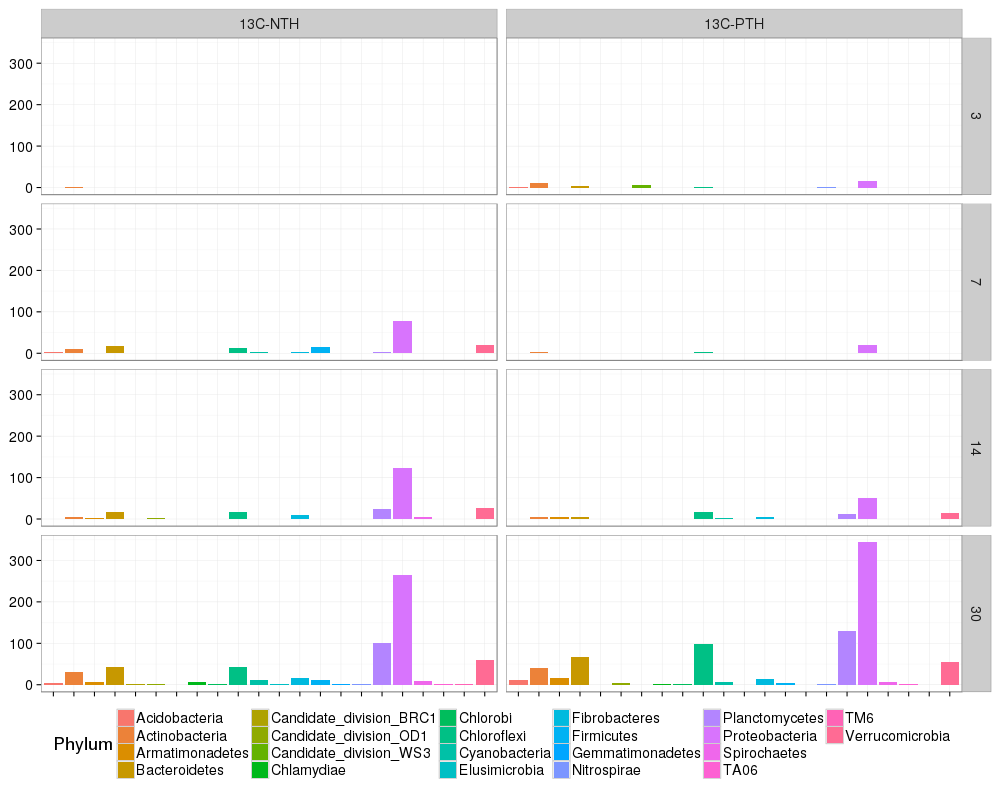

In [14]:
%%R -w 1000 -h 800
p.bar = ggplot(df.l2fc.f.f.sig, aes(Rank2)) +
geom_bar(stat = "count", na.rm = TRUE, aes(fill = Rank2)) + facet_grid(Day ~ ls, scale = "fixed") +
theme_bw(18) + theme(axis.text.x = element_blank())  + xlab(NULL) + ylab(NULL) + scale_fill_discrete(name = 'Phylum') + 
guides(fill = guide_legend(ncol=6)) + theme(legend.position = "bottom")

p.bar

In [15]:
%%R -i figDir
outFile = 'Resp_bar_lfc_Cell.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.bar, width=14, height=8)

In [16]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_byPhylumX.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=4)

outFile = 'l2fc_sparCut0.3_byPhylumX2.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.l2fc.x, width=12, height=8)

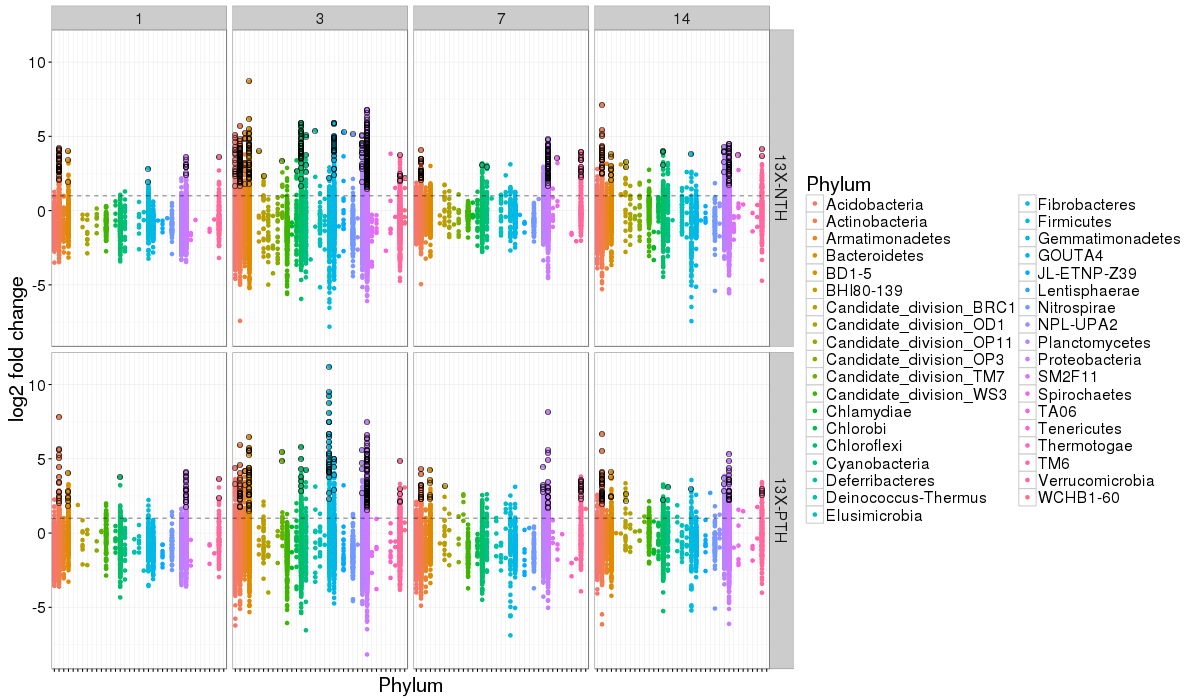

In [17]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13X') %>%
    mutate(Rank2 = Rank2 %>% as.character)


df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Day) +
    scale_color_discrete('Phylum') +
    labs(x = 'Phylum', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=20),
        axis.text.x = element_blank() 
        )
p.l2fc.x 

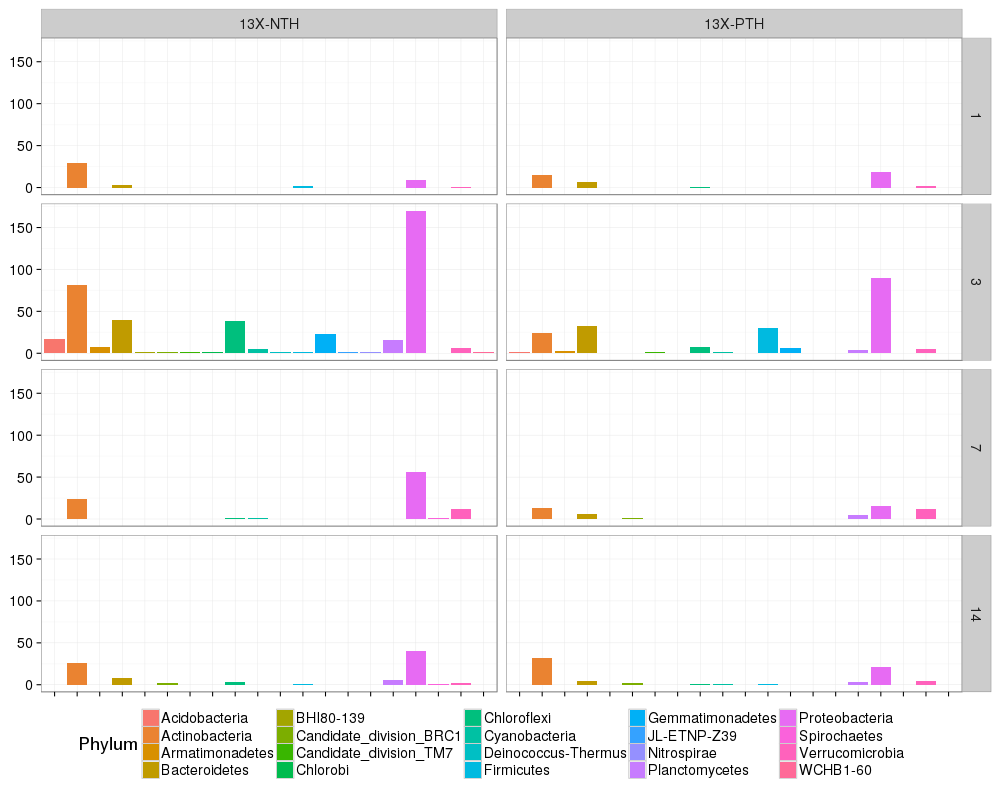

In [18]:
%%R -w 1000 -h 800
p.bar = ggplot(df.l2fc.f.f.sig, aes(Rank2)) +
geom_bar(stat = "count", na.rm = TRUE, aes(fill = Rank2)) + facet_grid(Day ~ ls, scale = "fixed") +
theme_bw(18) + theme(axis.text.x = element_blank())  + xlab(NULL) + ylab(NULL) + scale_fill_discrete(name = 'Phylum')+ 
guides(fill = guide_legend(ncol=6)) + theme(legend.position = "bottom")


p.bar

In [19]:
%%R -i figDir
outFile = 'Resp_bar_lfc_Xyl.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.bar, width=14, height=8)

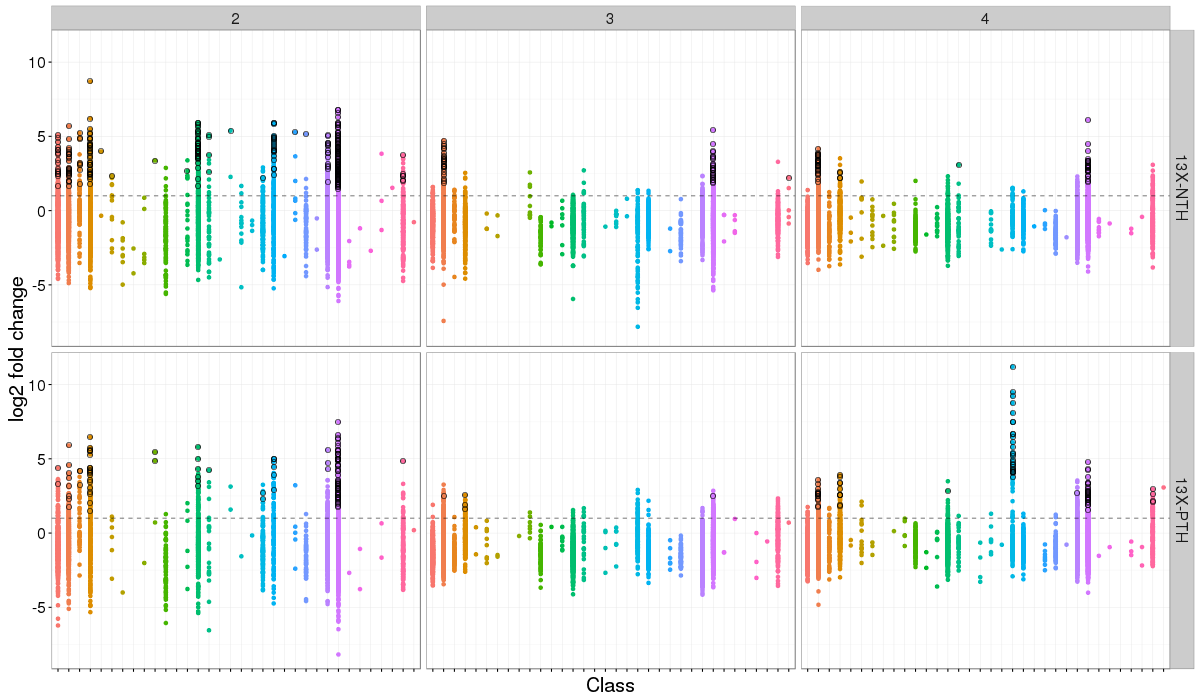

In [20]:
%%R -w 1200 -h 700
padj_cutoff = 0.10

df.l2fc.f.f = df.l2fc.f %>%
    filter(Substrate == '13X', Day == 3) %>%
    mutate(Rank3 = Rank3 %>% as.character)


df.l2fc.f.f = df.l2fc.f.f %>%
    mutate(Rank3 = gsub('^__', '', Rank3))

df.l2fc.f.f.sig = df.l2fc.f.f %>%
    filter(padj <= padj_cutoff) %>%
    mutate(Rank3 = gsub('^__', '', Rank3))

p.l2fc.x = ggplot(df.l2fc.f.f, aes(Rank2, color=Rank2)) +
    geom_point(aes(y=log2FoldChange)) +
    geom_point(data=df.l2fc.f.f.sig, aes(y=log2FoldChange), shape='O', color='black', alpha=0.8, size=2.5) +
    geom_hline(yintercept=l2fc_threshold, alpha=0.5, linetype='dashed') +
    facet_grid(ls~Replicate) +
    scale_color_discrete('Class') +
    labs(x = 'Class', y='log2 fold change') +
    theme_bw() +
    theme(
        text = element_text(size=20),
        axis.text.x = element_blank() 
        )+ guides(fill = FALSE, color = FALSE)
p.l2fc.x 

In [21]:
%%R
filter(df.l2fc.f.f, Replicate != 2) %>% group_by(Substrate, Day, Land_Management, Replicate) %>% summarise(num = n())

Source: local data frame [4 x 5]
Groups: Substrate, Day, Land_Management [?]

  Substrate   Day Land_Management Replicate   num
     (fctr) (int)          (fctr)     (int) (int)
1       13X     3             NTH         3  3817
2       13X     3             NTH         4  4656
3       13X     3             PTH         3  4299
4       13X     3             PTH         4  4545


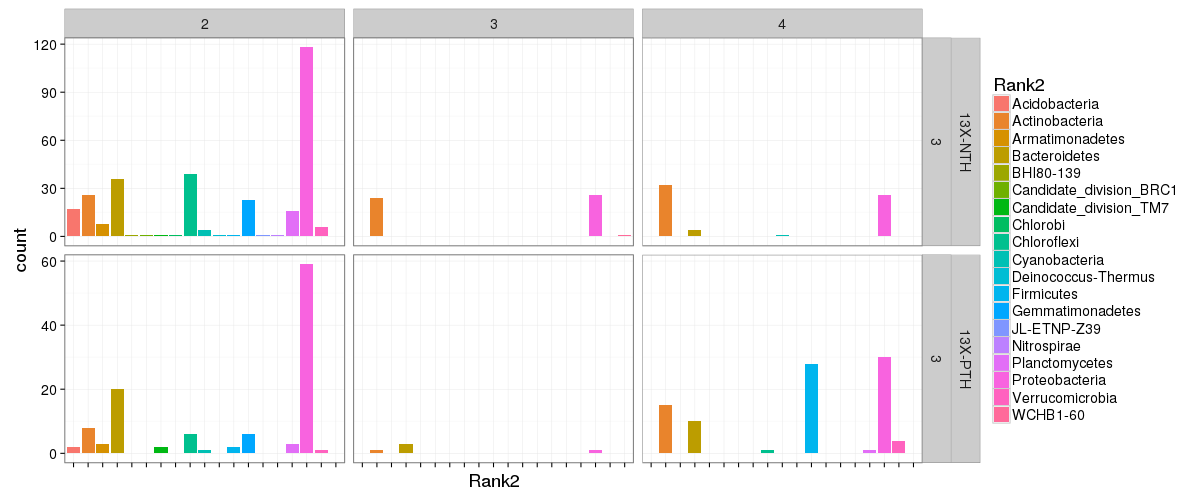

In [22]:
%%R -w 1200 -h 500
ggplot(df.l2fc.f.f.sig, aes(Rank2)) +
geom_bar(stat = "count", aes(fill = Rank2)) + facet_grid(Day~ls~Replicate, scale = "free_y") +
theme_bw(18) +  theme(axis.text.x = element_blank())

### Number of incorporators per treatment

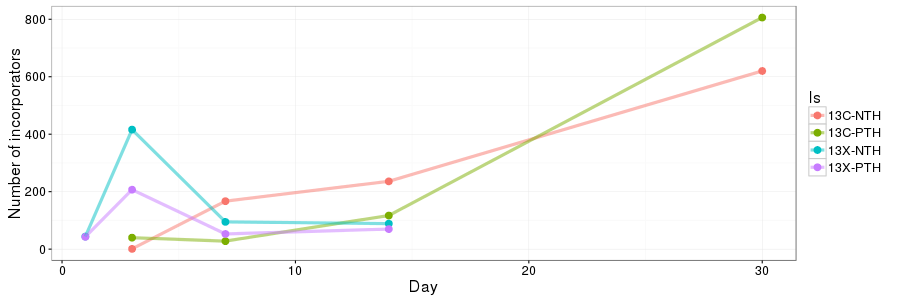

In [23]:
%%R -w 900 -h 300

padj_cutoff = 0.10

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(ls, Day) %>%
    summarize(n = sum(padj <= padj_cutoff))

p.nInc = ggplot(df.l2fc.f.sig, aes(Day, n, color=ls, group=ls)) +
    geom_point(size=3) +
    geom_line(size=1.5, alpha=0.5) +
    labs(y='Number of incorporators') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )
p.nInc

In [24]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_nInc.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc, width=10, height=3.5)

### Number of incorporators normalized by number of taxa in each sample

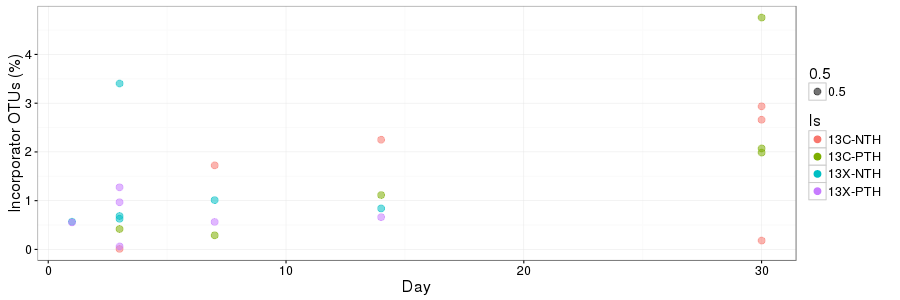

In [25]:
%%R -w 900 -h 300

padj_cutoff = 0.10

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(Substrate, Day, Replicate) %>%
    mutate(ntaxa = n()) %>%
    group_by(ls, Day, ntaxa, Replicate) %>%
    summarize(n_incorp = sum(padj <= padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100)

p.nInc.norm = ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color= ls, group=ls,
                                         alpha = 0.5)) +
    geom_point(size= 3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        )
p.nInc.norm

In [26]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_nIncNorm.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm, width=10, height=3.5)

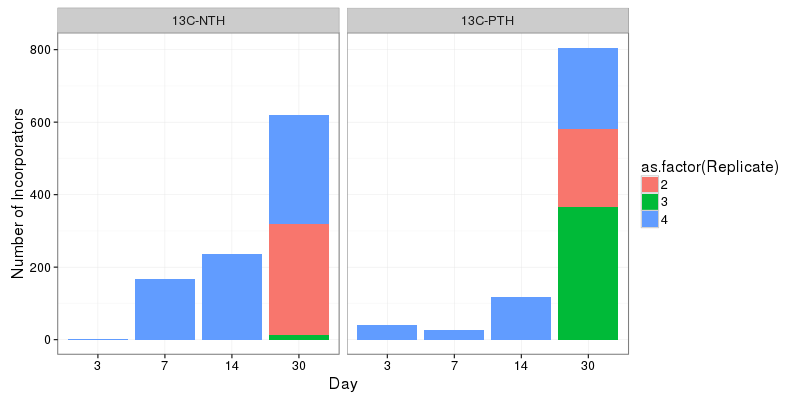

In [27]:
%%R -w 800 -h 400
Cel = filter(df.l2fc.f.sig, ls %in% c("13C-NTH", "13C-PTH"))
p = ggplot(Cel, aes(as.factor(Day), n_incorp, fill = as.factor(Replicate)))
p = p + geom_bar(stat = "identity")
p = p + facet_wrap(~ls, ncol = 2) + theme_bw(16) + labs(x = "Day", y = "Number of Incorporators")
p

In [28]:
%%R
ggsave(file ='data/figs/NumberIncorps_Time_Cellulose.jpg', p, width=8, height=4)

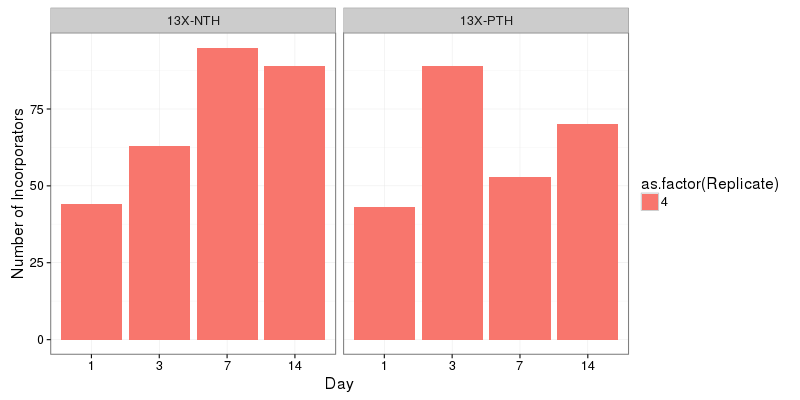

In [29]:
%%R -w 800 -h 400
Xyl = filter(df.l2fc.f.sig, ls %in% c("13X-NTH", "13X-PTH"), Replicate ==4)
p = ggplot(Xyl, aes(as.factor(Day), n_incorp, fill = as.factor(Replicate)))
p = p + geom_bar(stat = "identity")
p = p + facet_wrap(~ls, ncol = 2) + theme_bw(16) + labs(x = "Day", y = "Number of Incorporators")
p

In [30]:
%%R
ggsave(file ='data/figs/NumberIncorps_Time_Xylose.jpg', p, width=8, height=4)

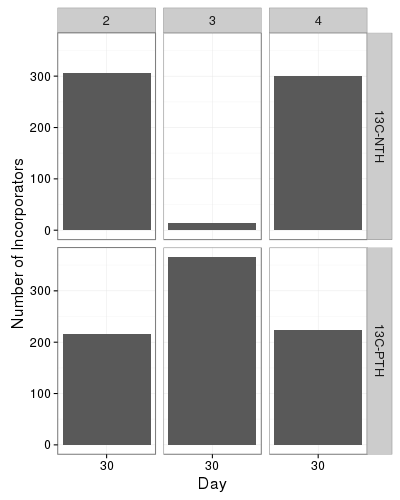

In [31]:
%%R -w 400 -h 500
Xyl2 = filter(df.l2fc.f.sig, ls %in% c("13C-NTH", "13C-PTH"), Day ==30)
p = ggplot(Xyl2, aes(as.factor(Day), n_incorp))
p = p + geom_bar(stat = "identity")
p = p + facet_grid(ls~Replicate) + theme_bw(16) + labs(x = "Day", y = "Number of Incorporators")
p

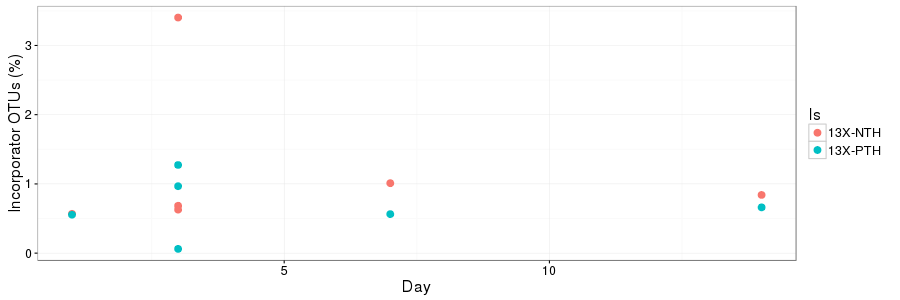

In [32]:
%%R -w 900 -h 300

padj_cutoff = 0.10

labile.sub = c("13X-NTH", "13X-PTH")

df.l2fc.f.sig.l = df.l2fc.f.sig %>%
    filter(ls %in% labile.sub)


p.nInc.norm.labile = ggplot(df.l2fc.f.sig.l, aes(Day, n_incorp_norm_perc, color=ls)) +
    geom_point(size=3) +
    #geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1) 
        ) 
p.nInc.norm.labile

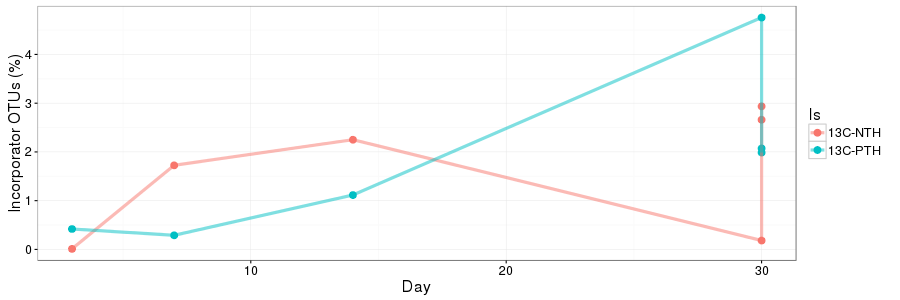

In [33]:
%%R -w 900 -h 300

padj_cutoff = 0.10

recal.sub = c("13C-NTH", "13C-PTH")

df.l2fc.f.sig.l = df.l2fc.f.sig %>%
    filter(ls %in% recal.sub)


p.nInc.norm.recal = ggplot(df.l2fc.f.sig.l, aes(Day, n_incorp_norm_perc, color=ls, group=ls)) +
    geom_point(size=3) +
    geom_line(size=1.5, alpha=0.5) +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16),
        axis.title.y = element_text(vjust=1)
        )
p.nInc.norm.recal

In [34]:
%%R -i figDir
outFile = 'l2fc_sparCut0.3_nIncNorm-labile.pdf'
outFile = paste(c(figDir, outFile), collapse='/')
ggsave(outFile, p.nInc.norm.labile, width=10, height=3.5)

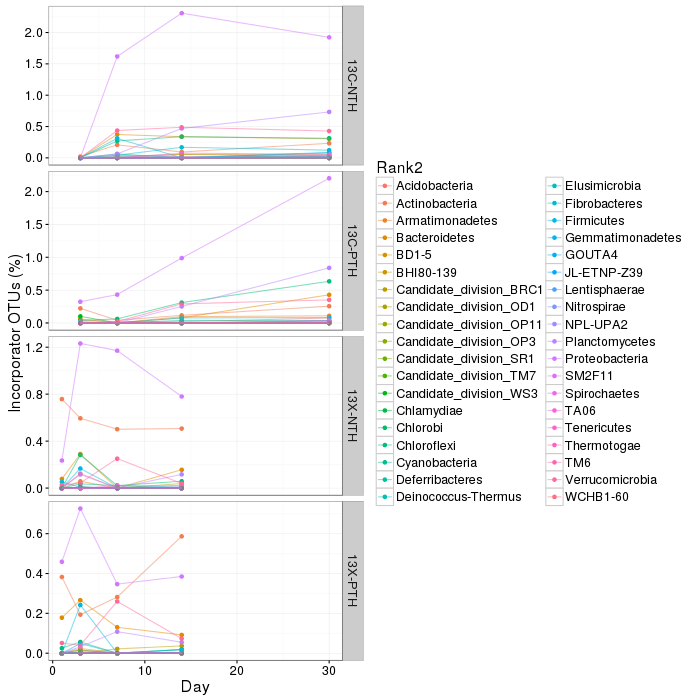

In [35]:
%%R -w 700 -h 700

padj_cutoff = 0.10

df.l2fc.f.sig = df.l2fc.f %>%
    group_by(ls, Day) %>%
    mutate(ntaxa = n()) %>%
    group_by(ls, Day, Rank2, ntaxa) %>%
    summarize(n_incorp = sum(padj <= padj_cutoff)) %>%
    mutate(n_incorp_norm_perc = n_incorp / ntaxa * 100) %>%
    ungroup %>%
    mutate(Rank2 = gsub('^__', '', Rank2))

ggplot(df.l2fc.f.sig, aes(Day, n_incorp_norm_perc, color=Rank2, group=Rank2)) +
    geom_point() +
    geom_line(alpha=0.5) +
    facet_grid(ls ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

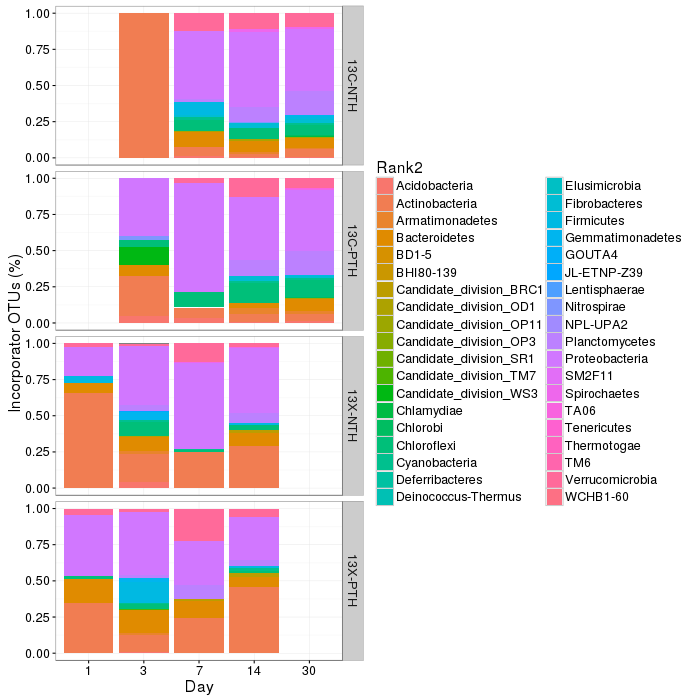

In [36]:
%%R -w 700 -h 700

tmp = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character)

tmp$Day = reorder(tmp$Day, tmp$Day %>% as.numeric)

ggplot(tmp, aes(Day, n_incorp_norm_perc, fill=Rank2, group=Rank2)) +
    geom_bar(stat='identity', position='fill') +
    facet_grid(ls ~ ., scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

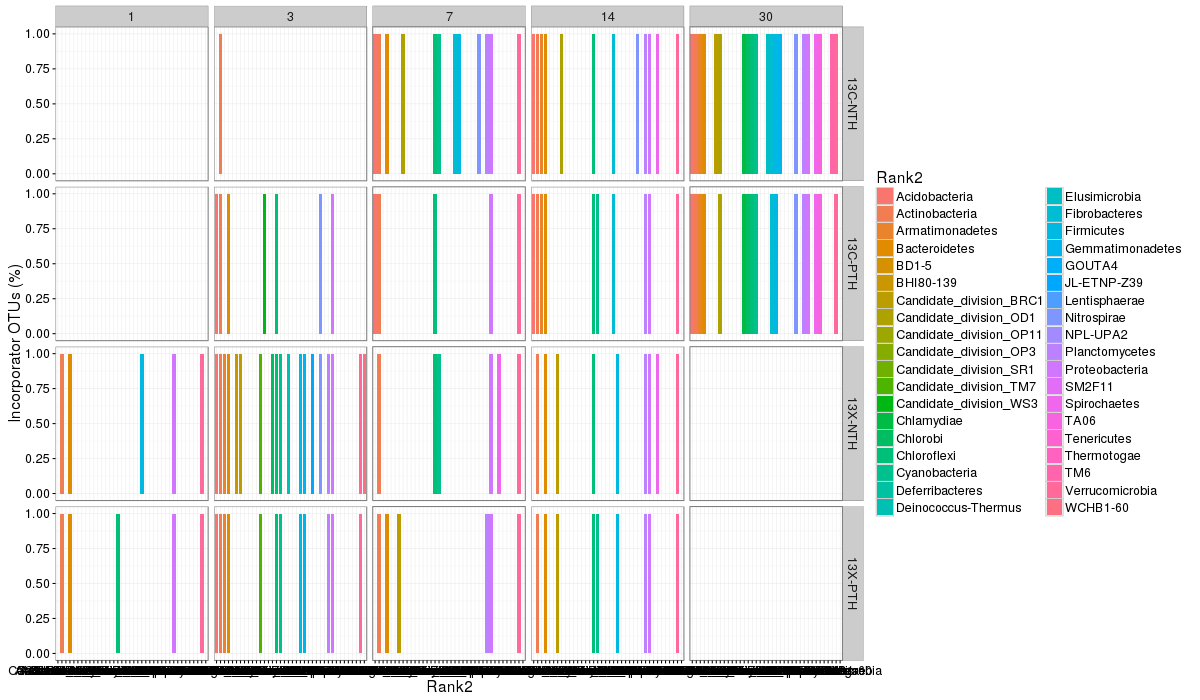

In [37]:
%%R -w 1200 -h 700

tmp = df.l2fc.f.sig %>%
    mutate(Day = Day %>% as.character)

tmp$Day = reorder(tmp$Day, tmp$Day %>% as.numeric)

ggplot(tmp, aes(Rank2, n_incorp_norm_perc, fill=Rank2, group=Rank2)) +
    geom_bar(stat='identity', position='fill') +
    facet_grid(ls ~ Day, scales='free_y') +
    labs(y='Incorporator OTUs (%)') +
    theme_bw() +
    theme(
        text = element_text(size=16)
        )

## Comparing LFC between Replicates

In [67]:
%%R
head(df.l2fc.f)

df.2 = filter(df.l2fc.f, Replicate == 2)
df.2$LFC2 = df.2$log2FoldChange
df.2$p2 = df.2$padj
df.2$log2FoldChange = NULL
df.2$padj = NULL
df.2 = select(df.2, LFC2, p2, OTU)

df.3 = filter(df.l2fc.f, Replicate == 3)
df.3$LFC3 = df.3$log2FoldChange
df.3$p3 = df.3$padj
df.3$log2FoldChange = NULL
df.3$padj = NULL
df.3 = select(df.3, LFC3, p3, OTU)


df.4 = filter(df.l2fc.f, Replicate == 4)
df.4$LFC4 = df.4$log2FoldChange
df.4$p4 = df.4$padj
df.4$log2FoldChange = NULL
df.4$padj = NULL
df.4 = select(df.4, LFC4, p4, OTU)


df.all = full_join(df.2, df.3)
df.all = full_join(df.all, df.4)

head(df.all)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: Joining by: "OTU"

  res = super(Function, self).__call__(*new_args, **new_kwargs)


        LFC2 p2      OTU      LFC3 p3       LFC4 p4
1 -0.4612852  1 OTU.4940        NA NA -1.0827550  1
2  1.3407702  1 OTU.1739 0.7653186  1  0.3032766  1
3  1.3407702  1 OTU.1739 0.7653186  1 -0.8404095  1
4  1.3407702  1 OTU.1739 0.7653186  1 -0.3823833  1
5  1.3407702  1 OTU.1739 0.7653186  1  0.7111412  1
6  1.3407702  1 OTU.1739 0.7653186  1 -0.8017693  1


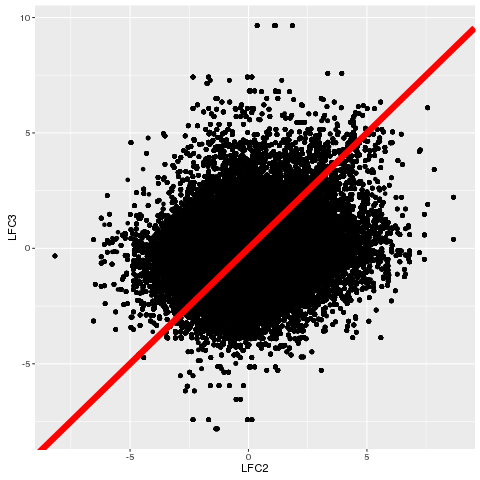

In [73]:
%%R
ggplot(data = df.all, aes(LFC2, LFC3), na.rm = TRUE) + geom_point() + 
        geom_abline(intercept = 0, slope = 1, color = 'red', size = 3)

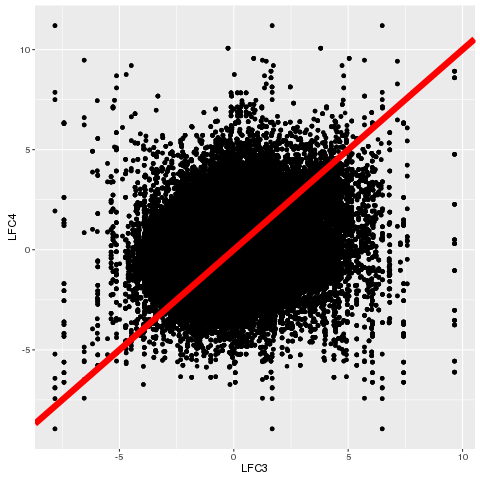

In [75]:
%%R
ggplot(data = df.all, aes(LFC3, LFC4), na.rm = TRUE) + geom_point() + 
        geom_abline(intercept = 0, slope = 1, color = 'red', size = 3)

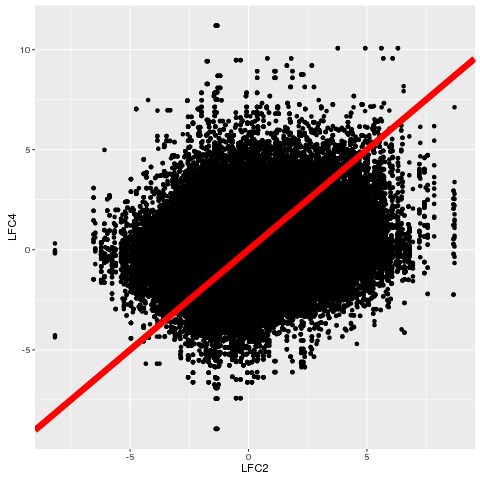

In [76]:
%%R
ggplot(data = df.all, aes(LFC2, LFC4), na.rm = TRUE) + geom_point()+ 
        geom_abline(intercept = 0, slope = 1, color = 'red', size = 3)

In [77]:
%%R
df.comp.sig = filter(df.all, p2 <= 0.10 | p3 <=0.10 | p4 <=0.10)

In [82]:
%%R
head(df.comp.sig)
length(unique(df.comp.sig$OTU))

[1] 1298


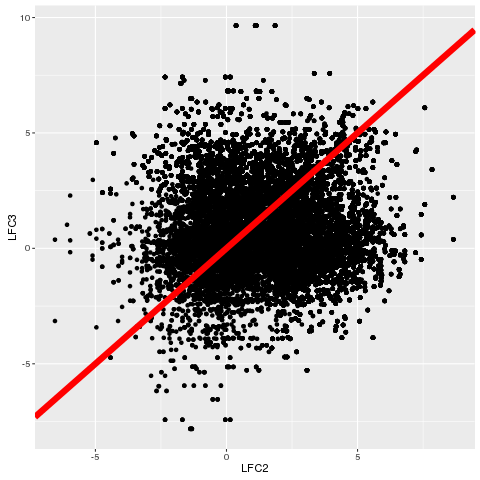

In [79]:
%%R
ggplot(data = df.comp.sig, aes(LFC2, LFC3), na.rm = TRUE) + geom_point() + 
        geom_abline(intercept = 0, slope = 1, color = 'red', size = 3) 

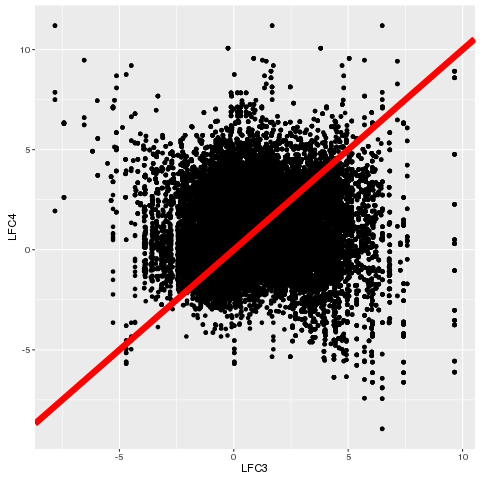

In [80]:
%%R
ggplot(data = df.comp.sig, aes(LFC3, LFC4), na.rm = TRUE) + geom_point() + 
        geom_abline(intercept = 0, slope = 1, color = 'red', size = 3)

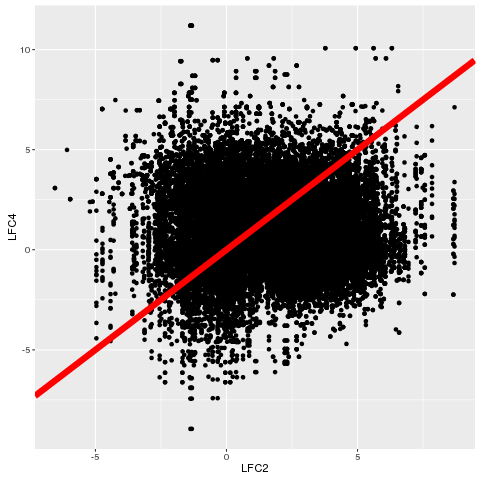

In [81]:
%%R
ggplot(data = df.comp.sig, aes(LFC2, LFC4), na.rm = TRUE) + geom_point()+ 
        geom_abline(intercept = 0, slope = 1, color = 'red', size = 3)